## Instance segmentation

The goal of this notebook is to finetune a pre-trained Mask R-CNN model on the Penn Fudan dataset. 

## Installing modules, downloading data

Let's install `pycocotools` library download the dataset.

In [ ]:
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
!unzip PennFudanPed.zip

## Writing custom Dataset class

Let's create a custom dataset inherited from `torch.utils.data.Dataset` for this task.

In [3]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image, ImageDraw

In [4]:
class PennFudanDataset(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(path, 'PNGImages'))))
        self.masks = list(sorted(os.listdir(os.path.join(path, 'PedMasks'))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, 'PNGImages', self.imgs[idx])
        img = Image.open(img_path).convert('RGB')

        mask_path = os.path.join(self.path, 'PedMasks', self.masks[idx])
        mask = Image.open(mask_path)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        boxes = []
        n_objects = len(obj_ids)
        for i in range(n_objects):
            mask_positions = np.where(masks[i] == True)
            x_min = np.min(mask_positions[1])
            x_max = np.max(mask_positions[1])
            y_min = np.min(mask_positions[0])
            y_max = np.max(mask_positions[0])
            boxes.append([x_min, y_min, x_max, y_max])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        labels = torch.ones((n_objects,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        is_crowd = torch.zeros((n_objects,), dtype=torch.int64)

        target = {'boxes': boxes, 
                  'labels': labels,
                  'masks': masks, 
                  'image_id': image_id,
                  'area': area,
                  'iscrowd': is_crowd}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
        

    def __len__(self):
        return len(self.imgs)

Let's import some files from `torchvision` library, which might be helpful for training the model. 

In [ ]:
%%bash

git clone https://github.com/pytorch/vision.git
cd vision
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [6]:
import utils
import transforms as T
from engine import train_one_epoch, evaluate

In [7]:
# creating transformations during train and evaluation
train_transforms = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(prob=0.5)])
val_transforms = T.Compose([T.ToTensor()])

# creating datasets
train_dataset = PennFudanDataset('PennFudanPed', transforms=train_transforms)
val_dataset = PennFudanDataset('PennFudanPed', transforms=val_transforms)

# splitting the data to train and val
torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-50])
val_dataset = torch.utils.data.Subset(val_dataset, indices[-50:])

# creating data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, 
                                           shuffle=True, num_workers=4, 
                                           collate_fn=utils.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                         shuffle=False, num_workers=4,
                                         collate_fn=utils.collate_fn)

## Finetuning the model

We will use the pretrained Mask R-CNN model with all freezed weights except the weights in the heads for box prediction and mask prediction.

In [8]:
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [9]:
# two classes for the pedestrian and background
num_classes = 2

# creating a model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# freezing weights
for param in model.parameters():
    param.requires_grad = False

# changing box predictor and mask predictor heads
in_channels = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_channels, 
                                                  num_classes=num_classes)

in_channels_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
dim_reduced = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_channels_mask,
                                                   dim_reduced=dim_reduced,
                                                   num_classes=num_classes)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [11]:
N_EPOCHS = 20
opt = torch.optim.Adam(model.parameters(), lr=5e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)

Let's train the model using methods from `torchvision` library, which provide detailed metrics.

In [12]:
for epoch in range(N_EPOCHS):
    train_one_epoch(model, opt, train_loader, device, epoch, print_freq=20)
    lr_scheduler.step()
    evaluate(model, val_loader, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/60]  eta: 0:01:08  lr: 0.000090  loss: 4.6415 (4.6415)  loss_classifier: 0.7949 (0.7949)  loss_box_reg: 0.3921 (0.3921)  loss_mask: 3.4276 (3.4276)  loss_objectness: 0.0213 (0.0213)  loss_rpn_box_reg: 0.0056 (0.0056)  time: 1.1480  data: 0.4570  max mem: 933
Epoch: [0]  [20/60]  eta: 0:00:11  lr: 0.001783  loss: 1.0399 (1.6501)  loss_classifier: 0.2704 (0.3679)  loss_box_reg: 0.2277 (0.2462)  loss_mask: 0.5307 (1.0103)  loss_objectness: 0.0193 (0.0211)  loss_rpn_box_reg: 0.0026 (0.0046)  time: 0.2561  data: 0.0070  max mem: 1038
Epoch: [0]  [40/60]  eta: 0:00:05  lr: 0.003476  loss: 0.6074 (1.1687)  loss_classifier: 0.0658 (0.2339)  loss_box_reg: 0.0885 (0.1795)  loss_mask: 0.4168 (0.7265)  loss_objectness: 0.0257 (0.0244)  loss_rpn_box_reg: 0.0027 (0.0044)  time: 0.2445  data: 0.0073  max mem: 1167
Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.4264 (0.9539)  loss_classifier: 0.0429 (0.1753)  loss_box_reg: 0.0998 (0.1574)  loss_mask: 0.2735 (0.5946)  loss_obj

## Visualizations

Let's create a function, which will show the original image, the actual masks in the dataset and predicted masks from our model.

In [13]:
def visualize_predictions(model, val_dataset, index, alignment='horizontal'):
    assert (alignment == 'horizontal' or alignment == 'vertical'), 'The possible alignment is \'horizontal\' or \'vertical\''
    image, target = val_dataset[index]

    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])
    
    image = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())

    real_mask = torch.zeros(target['masks'][0].shape)
    for i in range(len(target['masks'])):
        real_mask += target['masks'][i].mul(255).byte()
    real_mask = Image.fromarray(real_mask.numpy())
    
    predicted_mask = torch.zeros(prediction[0]['masks'][0, 0].shape)
    for i in range(len(prediction[0]['masks'])):
        predicted_mask += prediction[0]['masks'][i, 0].mul(255).byte().cpu()
    predicted_mask = Image.fromarray(predicted_mask.numpy())

    if alignment == 'horizontal':
        new_image = Image.new('RGB', (image.width + real_mask.width + predicted_mask.width, image.height))
        new_image.paste(image, (0, 0))
        new_image.paste(real_mask, (image.width, 0))
        new_image.paste(predicted_mask, (image.width + real_mask.width, 0))
    else:
        new_image = Image.new('RGB', (image.width, (image.height + real_mask.height + predicted_mask.height)))
        new_image.paste(image, (0, 0))
        new_image.paste(real_mask, (0, image.height))
        new_image.paste(predicted_mask, (0, image.height + real_mask.height))
    
    return new_image


Let's have a look at some examples of visualizations.

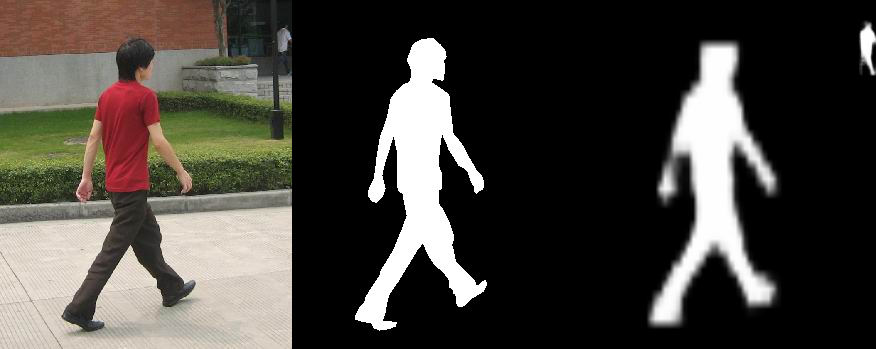

In [21]:
visualize_predictions(model, val_dataset, 0, alignment='horizontal')

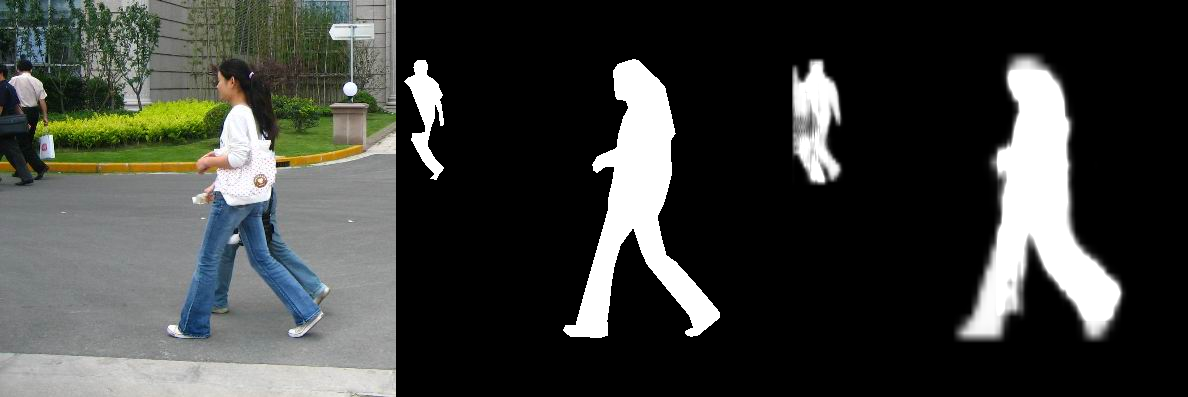

In [22]:
visualize_predictions(model, val_dataset, 5, alignment='horizontal')

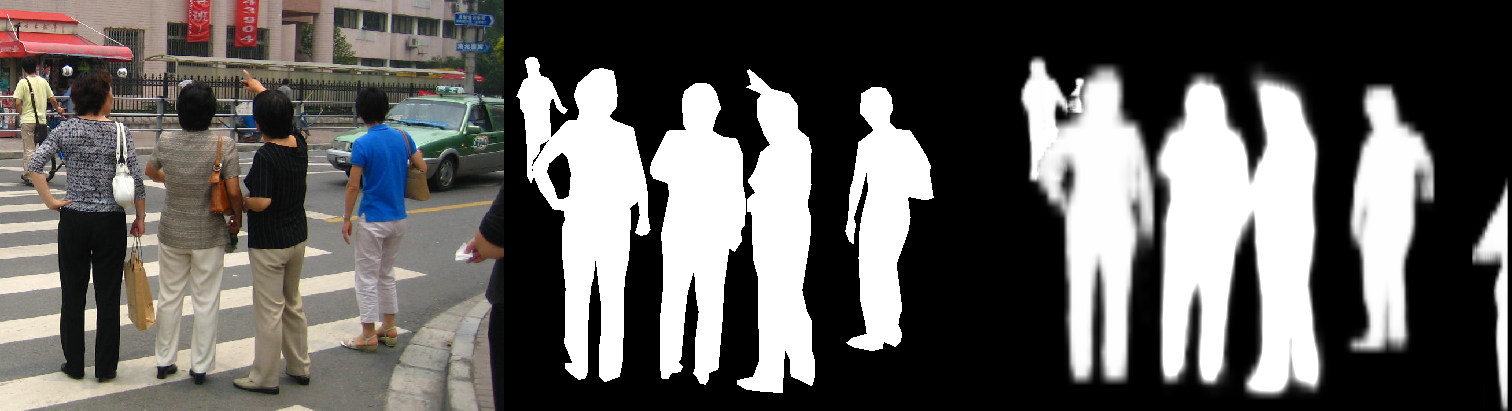

In [23]:
visualize_predictions(model, val_dataset, 10, alignment='horizontal')

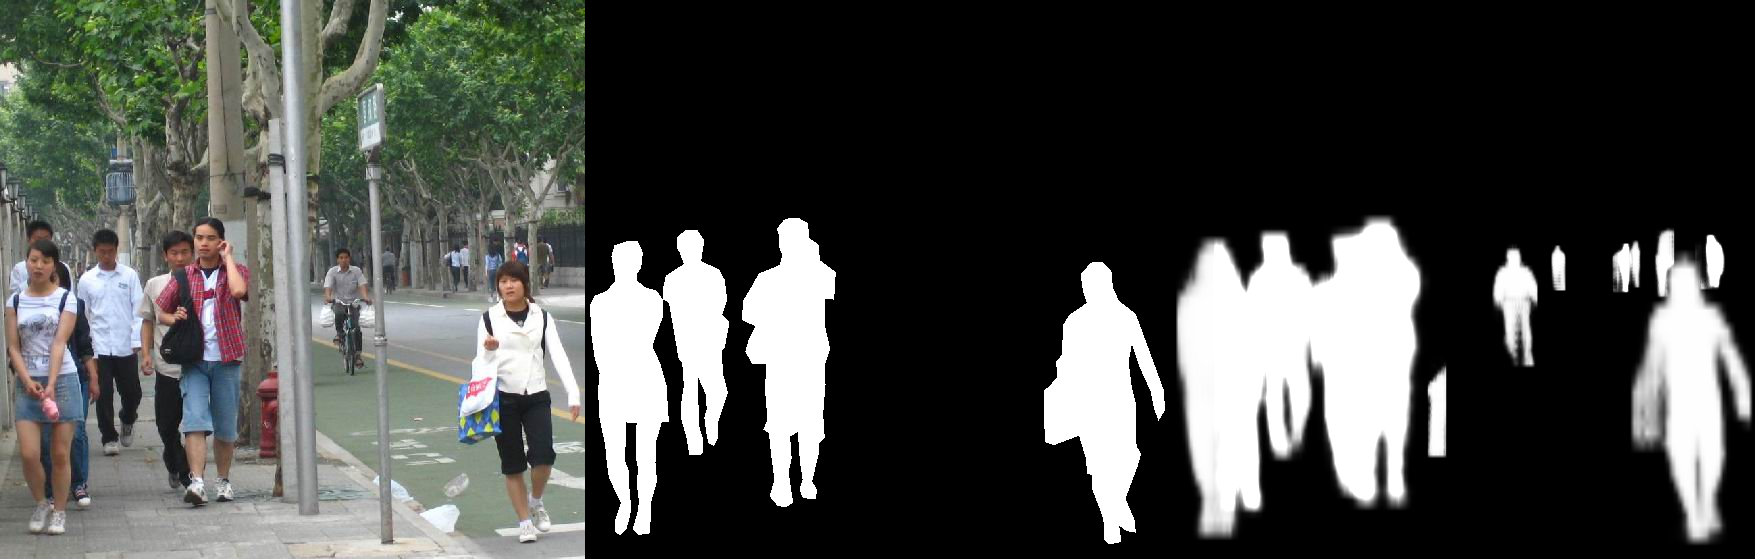

In [24]:
visualize_predictions(model, val_dataset, 15, alignment='horizontal')

It's quite common that our finetuned model detects even more people on the picture than it is in the masks in the dataset. It finds people who are in the background. Such examples are provided above.